In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import glob
from tqdm import tqdm
import itertools
from scipy.spatial.transform import Rotation

In [2]:
with open("/root/data/smartwatch/subjects_2023-06-27/valid_files.txt") as f:
    valid_files = f.readlines()
    valid_files = [x.strip() for x in valid_files]

In [3]:
mocap_files = ["/root/data/smartwatch/subjects_2023-06-27/" + file + "_mocap.csv" for file in valid_files]

In [4]:
df_ts = pd.read_csv("/root/tia/syde770-project/valid_files_start_end.csv", index_col=0)

In [5]:
df_ts

,file,start,end,longest
0,S01/S01_E1_R_1,0.333185,27.864334,28.039185
1,S01/S01_E1_R_2,0.434373,22.896181,23.139450
2,S01/S01_E2_R_1,0.278135,40.134510,40.225212
3,S01/S01_E2_R_2,0.243007,41.959816,42.030598
4,S01/S01_E3_R_1,0.216007,50.104893,50.155487
...,...,...,...,...
660,S40/S40_E7_R_2,0.235405,62.839060,62.891490
661,S40/S40_E8_R_1,0.253755,50.211586,50.282364
662,S40/S40_E8_R_2,0.229114,41.138256,41.193310
663,S40/S40_E9_R_1,0.303038,69.334990,69.548380


In [6]:
def load_df(fp):
    # Read the header of the file to get columns and frequency info
    with open(fp, 'r') as f:
        old_line = ""
        new_line = ""
        frequency = None
        for skip_lines, new_line in enumerate(f):
            if len([x for x in old_line.split(",") if x]) > 5:
                break  # Stop when we encounter the first very long header row
            if old_line.lower().strip() == "trajectories":
                frequency = float(new_line.split(",")[0])  # Sometimes frequency has ",hz" on the same line
            old_line = new_line
    subject = fp.split("/")
    header = old_line.split(",")
    header_markers = [col.split(':')[-1] for col in header]
    # We need radial styloid (RS), ulnar styloid (US), medial epicondyle (ME), and lateral epicondyle (LE)
    # for computing forearm orientation and positions
    markers = ["R_RS", "R_US", "R_ME", "R_LE"]
    col_names = [f"{marker}_{axis}" for marker, axis in itertools.product(markers, "XYZ")]
    col_inds = []
    for marker in markers:
        i = header_markers.index(marker)
        col_inds.extend([i, i+1, i+2])  

    # Sort by names by index, pandas usecols arg uses sorted column order
    col_inds, col_names = list(zip(*sorted(zip(col_inds, col_names))))

    df = pd.read_csv(fp, skiprows=skip_lines + 2, usecols=col_inds, names=col_names)
    df.index = pd.to_timedelta(df.index / frequency, unit="seconds")
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    return df

For files that have less than 100 NaN values, fill those. Otherwise, just discard them.

In [8]:
nan_files = []
old_nan_series = []

for file in valid_files:
    mocap_file = "/root/data/smartwatch/subjects_2023-06-27/" + file + "_mocap.csv"
    df = load_df(mocap_file)
    
    # start = df_ts.loc[df_ts["file"] == file, "start"].values[0]
    # end = df_ts.loc[df_ts["file"] == file, "end"].values[0]
    # mask = (df.index > pd.Timedelta(start, unit="s")) & (df.index < pd.Timedelta(end, unit="s"))
    
    # df = df[mask]
    no_nan = df.dropna(axis=0)
    n = len(df)
    m = n - len(no_nan)
    if m == 0:
        continue
    nan_files.append(file)
    old_nan_series.append(df.isna().any(axis=1).values)
    print(file)
    print(f"\t {m} / {n} = {m/n * 100:.2f}% rows are NaN")

S01/S01_E7_R_1B
	 17 / 2359 = 0.72% rows are NaN
S01B/S01B_E1_R_1
	 1 / 988 = 0.10% rows are NaN
S01B/S01B_E5_R_2
	 14 / 2528 = 0.55% rows are NaN
S01B/S01B_E8_R_2
	 1735 / 2939 = 59.03% rows are NaN
S01B/S01B_E9_R_2
	 34 / 3735 = 0.91% rows are NaN
S02/S02_E3_R_1
	 1 / 2542 = 0.04% rows are NaN
S02/S02_E7_R_2
	 2 / 2795 = 0.07% rows are NaN
S02B/S02B_E7_R_2
	 2 / 2890 = 0.07% rows are NaN
S03/S03_E5_R_1
	 1 / 1933 = 0.05% rows are NaN
S03/S03_E7_R_1
	 7 / 3418 = 0.20% rows are NaN
S03/S03_E7_R_2
	 1 / 2716 = 0.04% rows are NaN
S03B/S03B_E5_R_1
	 21 / 2567 = 0.82% rows are NaN
S03B/S03B_E5_R_2
	 50 / 2240 = 2.23% rows are NaN
S04/S04_E7_R_1
	 36 / 2555 = 1.41% rows are NaN
S04B/S04B_E1_R_1
	 1 / 1222 = 0.08% rows are NaN
S04B/S04B_E1_R_2
	 3 / 790 = 0.38% rows are NaN
S04B/S04B_E8_R_2
	 28 / 1604 = 1.75% rows are NaN
S04B/S04B_E9_R_2
	 1 / 2654 = 0.04% rows are NaN
S05/S05_E3_R_1
	 8 / 5303 = 0.15% rows are NaN
S05/S05_E4_R_1
	 21 / 4108 = 0.51% rows are NaN
S05/S05_E7_R_1
	 1 / 3496 =

NaN Rules:
- If there are more than 2 breakpoints and more than 100 points, don't bother filling, don't use the data
- If there are only 2 breakpoints at the ends, just drop the ends
- If there are less than 100 points but they're in the middle, fill with linear interpolation

In [27]:
new_timecuts = {}
bad_files = []
nan_series = []
bad_index = []
i = -1

for file in valid_files:
    mocap_file = "/root/data/smartwatch/subjects_2023-06-27/" + file + "_mocap.csv"
    df = load_df(mocap_file)
    # Cut to 
    # start = df_ts.loc[df_ts["file"] == file, "start"].values[0]
    # end = df_ts.loc[df_ts["file"] == file, "end"].values[0]
    # mask = (df.index > pd.Timedelta(start, unit="s")) & (df.index < pd.Timedelta(end, unit="s"))
    
    # df = df[mask]
    if len(df) == 0:
        bad_files.append(file)
        continue

    nan_regions = df.isna().any(axis=1).values
    if sum(nan_regions) == 0:
        new_timecuts.setdefault("file", []).append(file)
        new_timecuts.setdefault("start", []).append(df.index[0].value / 1e9)  # ns to seconds
        new_timecuts.setdefault("end", []).append(df.index[-1].value / 1e9)
        continue
    breakpoints = np.diff(nan_regions)
    i += 1
    if (sum(nan_regions) > 100) and (sum(breakpoints) > 2):
        bad_files.append(file)
        bad_index.append(i)
        nan_series.append(nan_regions)
        continue
    # Also drop ones where there are more than 100 missing points at the ends
    if (sum(nan_regions) > 50) and (nan_regions[0] == False) and (nan_regions[-1] == False):
        bad_files.append(file)
        bad_index.append(i)
        nan_series.append(nan_regions)
        continue
    # Fill inner missing values, often just single missing values
    df = df.interpolate(method="linear", axis=0, limit_area="inside")
    # If the nan regions on ends are too big, just ignore them
    if sum(nan_regions) / len(nan_regions) > 0.3:
        bad_files.append(file)
        bad_index.append(i)
        nan_series.append(nan_regions)
        continue
    df = df.dropna(axis=0)
    nan_regions = df.isna().any(axis=1).values
    nan_series.append(nan_regions)
    # Track new start/endpoints
    new_timecuts.setdefault("file", []).append(file)
    new_timecuts.setdefault("start", []).append(df.index[0].value / 1e9)  # ns to seconds
    new_timecuts.setdefault("end", []).append(df.index[-1].value / 1e9)

Text(0.5, 1.0, 'After NaN cleanup')

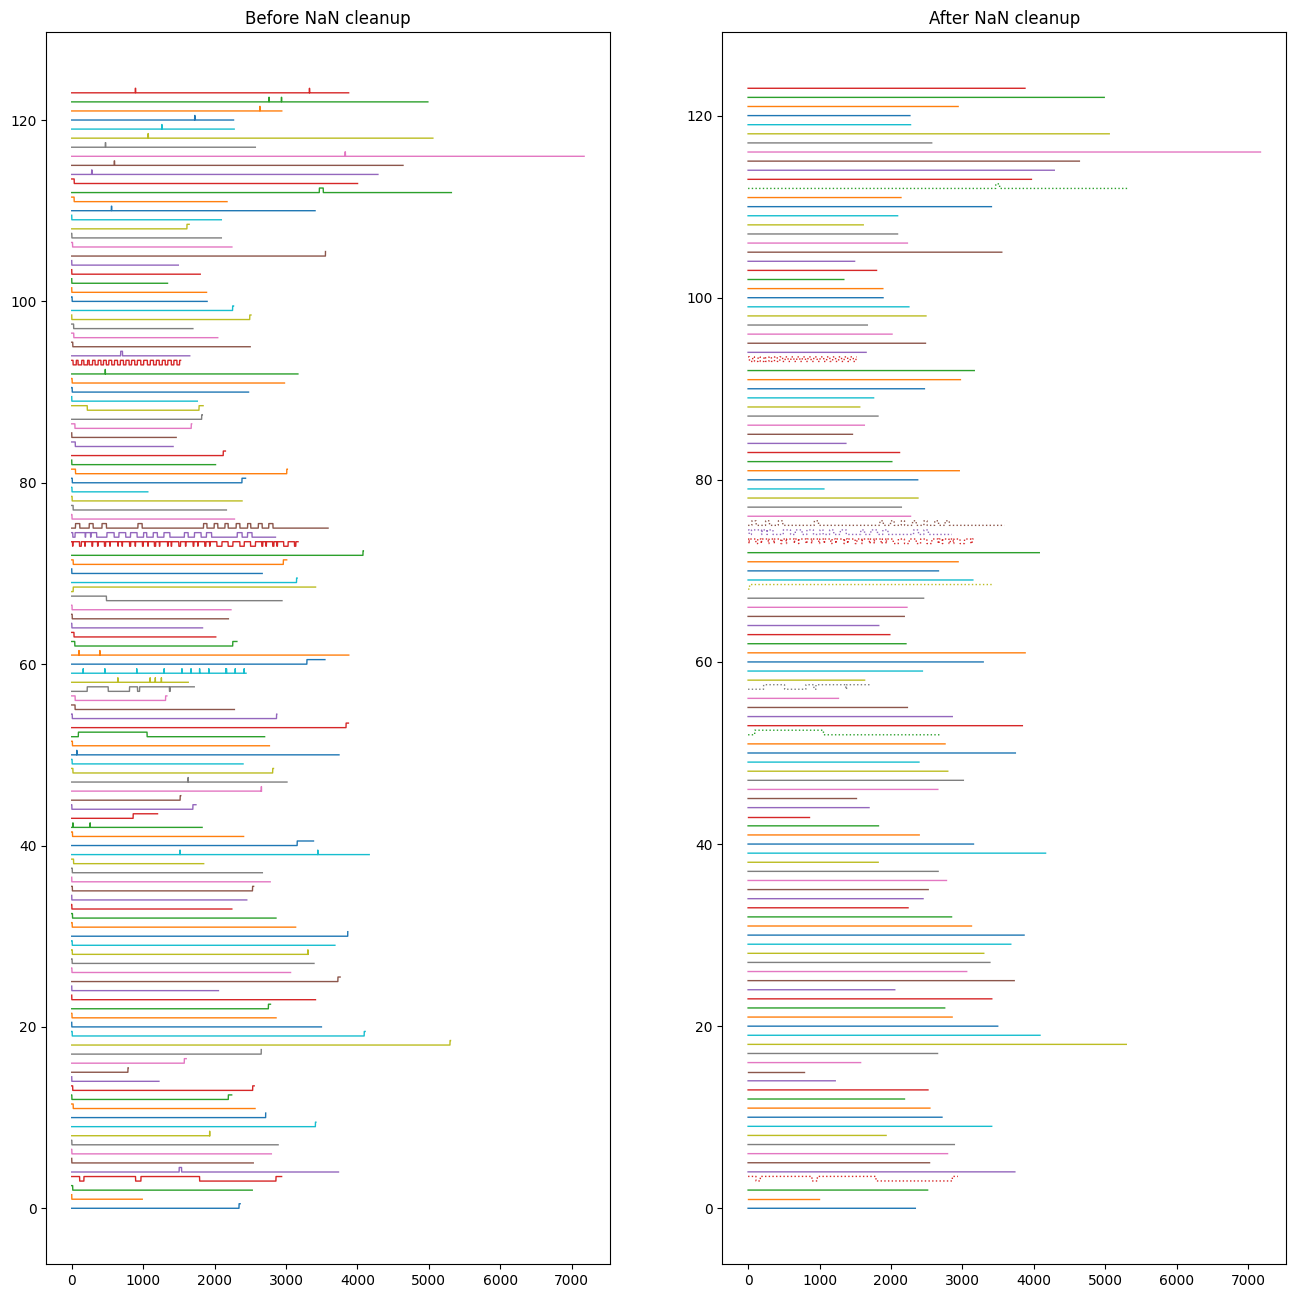

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))

for i, bp in enumerate(old_nan_series):
    axs[0].plot(bp / 2 + i, lw=1)
axs[0].set_title("Before NaN cleanup")

for i, bp in enumerate(nan_series):
    if i in bad_index:
        axs[1].plot(bp / 2 + i, linestyle="dotted", lw=1)
    else:
        axs[1].plot(bp / 2 + i, lw=1)
axs[1].set_title("After NaN cleanup")

In [29]:
df_new_ts = pd.DataFrame(new_timecuts)
df_new_ts

,file,start,end
0,S01/S01_E1_R_1,0.0,28.54
1,S01/S01_E1_R_2,0.0,23.02
2,S01/S01_E2_R_1,0.0,40.08
3,S01/S01_E2_R_2,0.0,41.08
4,S01/S01_E3_R_1,0.0,50.56
...,...,...,...
1195,S82B/S82B_E7_R_2,0.0,64.54
1196,S82B/S82B_E8_R_1,0.0,48.60
1197,S82B/S82B_E8_R_2,0.0,47.30
1198,S82B/S82B_E9_R_1,0.0,85.02


In [30]:
df_new_ts.to_csv("/root/data/smartwatch/analysis/mocap_valid_times_2023-06-27.csv", index=False)

# Process stats and normalize

In [31]:
import pickle
import numpy as np

with open("/root/data/smartwatch/analysis/mocap_global_stats_2023-06-27.pkl", "rb") as f:
    global_counters = pickle.load(f)

In [32]:
global_counters

{'X': Counter({22.0: 8543,
          3.0: 8419,
          -17.0: 8686,
          -36.0: 8830,
          -54.0: 9092,
          -71.0: 8832,
          -88.0: 8339,
          -103.0: 7749,
          -116.0: 7280,
          -128.0: 6487,
          -137.0: 6096,
          -144.0: 5579,
          -149.0: 5350,
          -151.0: 5275,
          -148.0: 5359,
          -142.0: 5767,
          -134.0: 6330,
          -123.0: 7016,
          -111.0: 7478,
          -96.0: 8188,
          -80.0: 8552,
          -62.0: 9176,
          -43.0: 8973,
          -23.0: 8935,
          -3.0: 8546,
          18.0: 8387,
          38.0: 8479,
          58.0: 8046,
          78.0: 7792,
          96.0: 7531,
          113.0: 6607,
          129.0: 5727,
          142.0: 5055,
          154.0: 4350,
          163.0: 4004,
          169.0: 3615,
          173.0: 3405,
          175.0: 3297,
          172.0: 3448,
          167.0: 3751,
          160.0: 4213,
          151.0: 4474,
          141.0: 5099,
   

In [33]:
global_stats = {}
for key, counter in global_counters.items():
    N = sum(counter.values())
    mu = sum([val * count for val, count in counter.items()]) / N
    sigma = np.sqrt(sum([(val - mu) ** 2 * count for val, count in counter.items()]) / N)
    global_stats[key] = {"mean": mu, "std": sigma}

In [34]:
global_stats

{'X': {'mean': 0.000156548163494357, 'std': 147.72637681257618},
 'Y': {'mean': -2.8405916763088975e-06, 'std': 123.70350552921091},
 'Z': {'mean': -5.049940757882484e-05, 'std': 254.36640652898615},
 'qx': {'mean': -0.05074639197513891, 'std': 0.3657220001412715},
 'qy': {'mean': 0.07298917292701494, 'std': 0.4709047618996284},
 'qz': {'mean': 0.1483032101210914, 'std': 0.5336451936044557},
 'qw': {'mean': 0.19254408724530137, 'std': 0.5410629185553384}}

In [15]:
%%timeit
a = list(counter.elements())
np.mean(a)
np.std(a)

178 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
mu = sum([val * count for val, count in counter.items()]) / N
sigma = np.sqrt(sum([(val - mu) ** 2 * count for val, count in counter.items()]) / N)

473 µs ± 8.98 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
